# Imports and definitions

In [1]:
import pandas as pd
import torch
import torchvision.transforms.functional as transform
import torchvision.transforms.functional as F
from EnsembleXAI import Ensemble, Metrics
from torchvision.transforms import Resize, CenterCrop
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import urllib.request
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients, Occlusion, NoiseTunnel, visualization as viz, Saliency
import matplotlib.pyplot as plt
import pickle

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)
with urllib.request.urlopen("https://raw.githubusercontent.com/LUSSeg/ImageNet-S/main/data/categories/ImageNetS_categories_im50.txt") as url:
    imagenetS50_ids_dict = {str(x).replace("b'", "").replace("\\n'", ""):i+1 for i, x in enumerate(url)}

In [3]:
def download_class_images(class_id, masks_path):
    full_path = masks_path + class_id + "\\"
    kaggle_path = f"/ILSVRC/Data/CLS-LOC/train/{class_id}/"
    for file_name in os.listdir(full_path):
        file_name_jpeg = file_name[:-3] + 'JPEG'
        !kaggle competitions download -f {kaggle_path}{file_name_jpeg} -p ./images/{class_id}/ -c imagenet-object-localization-challenge


def download():
    skipped = []
    for class_id in os.listdir(masks_dir):
        image_class_path = os.path.join(images_dir, class_id)
        if os.path.exists(image_class_path) and len(os.listdir(image_class_path)) == 10:
            skipped.append(class_id)
            continue
        #download_class_images(class_id, masks_dir)
        print(f"Downloaded {class_id}")
    print("Full dirs: " + str(len(skipped)))


def images_list(image_path, resize=True):
    _crop = CenterCrop(224).forward
    _resize = Resize(232).forward
    images = []
    for image_name in os.listdir(image_path):
        image = Image.open(image_path + image_name)
        if image.mode == 'L':
            image = image.convert(mode='RGB')
        if resize:
            image = _crop(_resize(image))
        images.append(image)
    return images

def load_all(classid):
    all_img = images_list(images_dir + classid + "\\")
    all_img_org = images_list(images_dir + classid + "\\", resize=False)
    all_tens = [F.to_tensor(img) for img in all_img]
    all_msks = [F.pil_to_tensor(img) for img in images_list(masks_dir + classid + "\\")]
    all_msks = [((temp[1] * 256 + temp[0]) == imagenetS50_ids_dict[classid]).float().repeat(3,1,1) for temp in all_msks]
    all_tens = [tens.repeat(3,1,1) if tens.shape[0]==1 else tens for tens in all_tens]
    tens_img = torch.stack(all_tens)
    tens_msks = torch.stack(all_msks)#[:,0].unsqueeze(dim=1).repeat(1, tens_img.shape[1], 1, 1)
    return all_img, all_img_org, all_tens, all_msks, tens_img, tens_msks

def dict_to_matrix(original_data, explanations_dict, predictor, masks_tensor):
    df = pd.DataFrame()
    #impact_thresh = 0.4
    #accordance_thresh = 0.2
    for key, value in explanations_dict.items():
        for thresh in range(10):
            df.loc[key, f"Decision Impact Ratio{thresh}"] = Metrics.decision_impact_ratio(original_data, predictor, value, thresh/10, 0)
            df.loc[key, f"Confidence Impact Ratio Same{thresh}"] = Metrics.confidence_impact_ratio(original_data, predictor, value, thresh/10, 0, compare_to="same_prediction")
            df.loc[key, f"CIR Max{thresh}"] = Metrics.confidence_impact_ratio(original_data, predictor, value, thresh/10, 0, compare_to="new_prediction")
            df.loc[key, f"Average Recall{thresh}"] = torch.mean(Metrics.accordance_recall(value, masks_tensor, thresh/10)).item()
            df.loc[key, f"Average Precision{thresh}"] = torch.mean(Metrics.accordance_precision(value, masks_tensor, thresh/10)).item()
        df.loc[key, "F1_score"] = Metrics.F1_score(explanations_dict[key], masks_tensor)
        df.loc[key, "IOU"] = Metrics.intersection_over_union(explanations_dict[key], masks_tensor)
    return df

# Images load

In [4]:
input_dir = "\\".join(os.getcwd().split(sep="\\")[:-2] + ['input'])
masks_dir = input_dir + f'\\ImageNetS50\\train-semi-segmentation\\'
images_dir = os.getcwd() + "\\images\\"
all_classes = next(os.walk(images_dir))[1]
print(all_classes)

['n01443537', 'n01491361', 'n01531178', 'n01644373', 'n02104029', 'n02119022', 'n02123597', 'n02133161', 'n02165456', 'n02281406', 'n02325366', 'n02342885', 'n02396427', 'n02483362', 'n02504458', 'n02510455', 'n02690373', 'n02747177', 'n02783161', 'n02814533', 'n02859443', 'n02917067', 'n02992529', 'n03014705', 'n03047690', 'n03095699', 'n03197337', 'n03201208', 'n03445777', 'n03452741', 'n03584829', 'n03630383', 'n03775546', 'n03791053', 'n03874599', 'n03891251', 'n04026417', 'n04335435', 'n04380533', 'n04404412', 'n04447861', 'n04507155', 'n04522168', 'n04557648', 'n04562935', 'n04612504', 'n06794110', 'n07749582', 'n07831146', 'n12998815']


In [5]:
id = all_classes[22]
print(id)
if not os.path.exists(f'results/{id}'):
    os.mkdir(f'results/{id}')
all_images, all_images_original, all_tensors, all_masks, tensor_images, tensor_masks = load_all(id)

n02992529


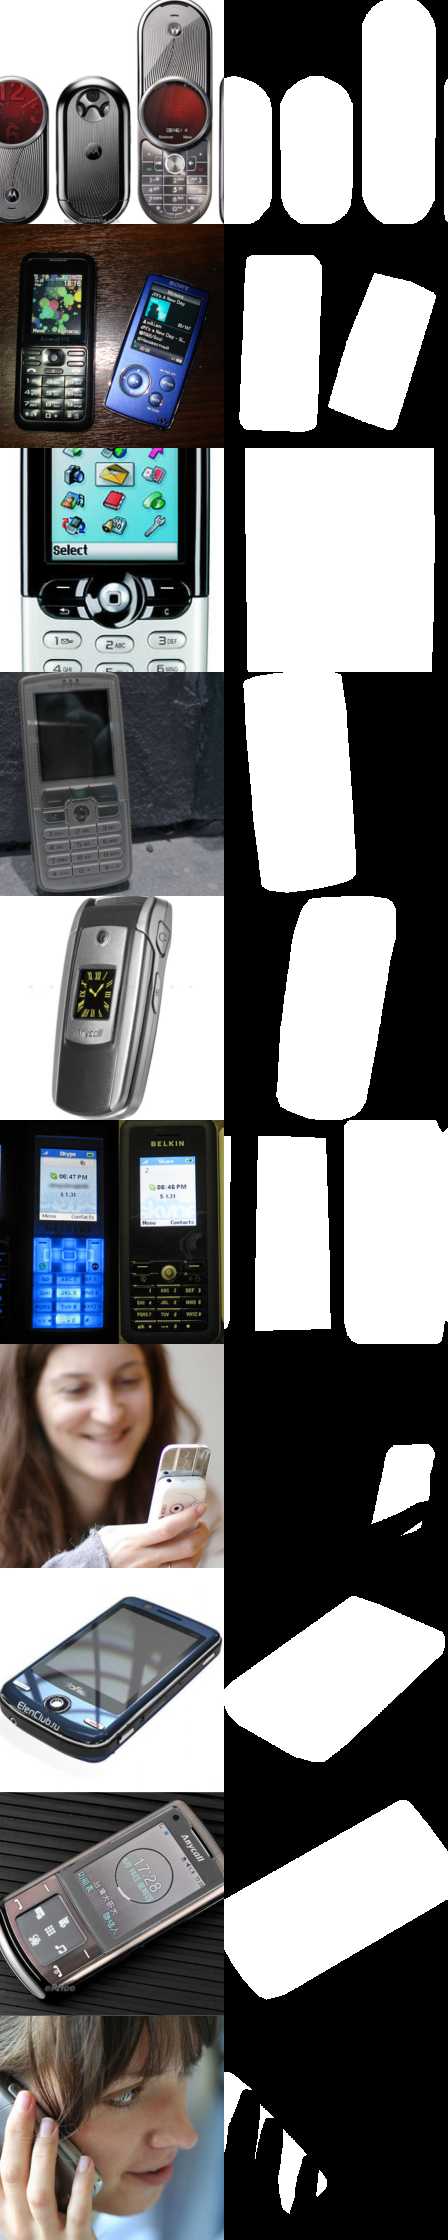

In [6]:
photos = []
for tensor, mask in zip(all_tensors, all_masks):
    photo = torch.cat([tensor, mask], dim=2)
    photos.append(photo)
display(transform.to_pil_image(torch.cat(photos, dim=1)))

# Model Loading

In [7]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
resnet_transform = ResNet50_Weights.DEFAULT.transforms()
pipeline = lambda images: torch.stack([resnet_transform(image) for image in images])
proper_data = pipeline(all_images_original)

In [8]:
outputs2 = model(proper_data)
_, preds2 = torch.max(outputs2, 1)
probs2 = torch.nn.functional.softmax(outputs2, dim=1)
[imagenet_classes_dict[str(i.item())][1] for i in preds2]

['cellular_telephone',
 'cellular_telephone',
 'cellular_telephone',
 'cellular_telephone',
 'cellular_telephone',
 'cellular_telephone',
 'cellular_telephone',
 'cellular_telephone',
 'cellular_telephone',
 'cellular_telephone']

# Single Explanations

In [9]:
single_pred = preds2[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

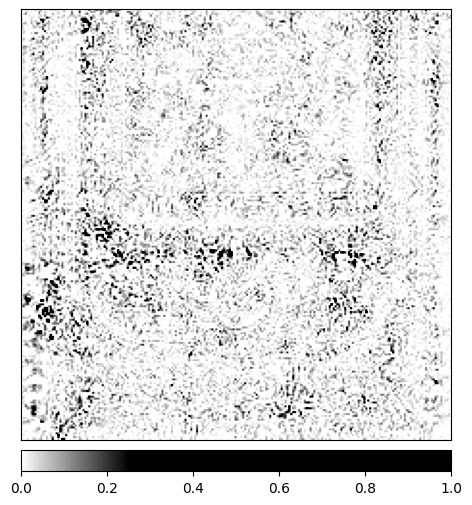

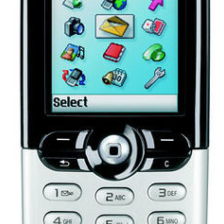

In [10]:
transformed_img = resnet_transform(all_images_original[2])
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
display(all_images[2])

In [11]:
import gc
gc.collect()

165

In [12]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(single_data, nt_samples=5, nt_type='smoothgrad_sq', target=single_pred)

In [13]:
attributions_ig_nt_all = torch.cat([noise_tunnel.attribute(tensor_images[i].unsqueeze(dim=0), nt_samples=5, nt_type='smoothgrad_sq', target=preds2[i].unsqueeze(dim=0)) for i in range(10)], dim=0)

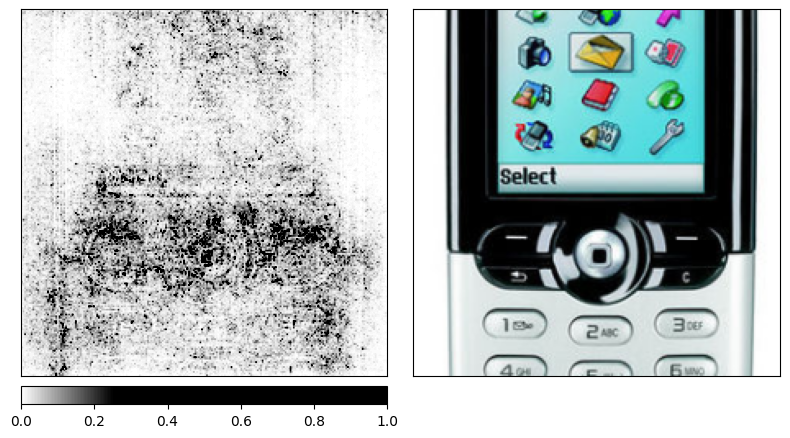

In [14]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [15]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(single_data,
                                       strides = (3, 8, 8),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

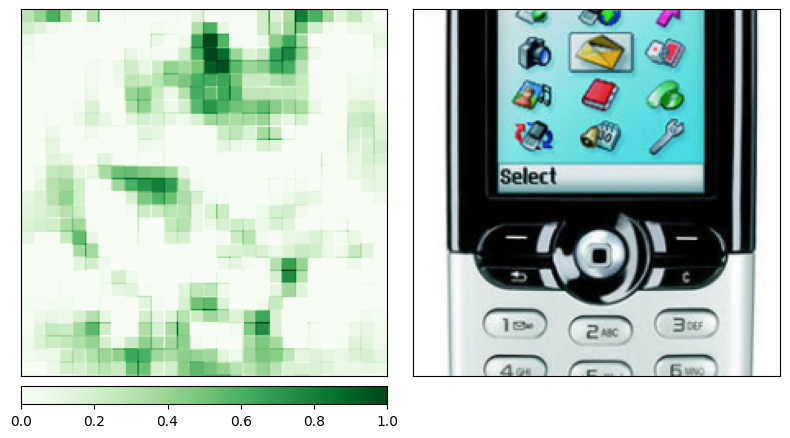

In [16]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

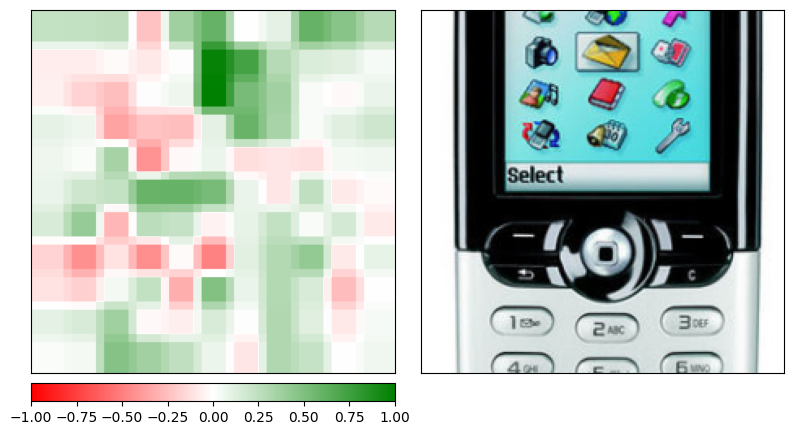

In [17]:
occlusion = Occlusion(model)

attributions_occ2 = occlusion.attribute(single_data,
                                       strides = (3, 20, 20),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 25, 25),
                                       baselines=0)
_2 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [18]:
occlusion = Occlusion(model)

attributions_occ_all_25 = occlusion.attribute(tensor_images,
                                        strides = (3, 20, 20),
                                        target = preds2,
                                        sliding_window_shapes = (3, 25, 25),
                                        baselines=0)

attributions_occ_all_15 = occlusion.attribute(tensor_images,
                                           strides = (3, 8, 8),
                                           target = preds2,
                                           sliding_window_shapes = (3, 15, 15),
                                           baselines=0)

In [19]:
saliency = Saliency(model)
attr_saliency = saliency.attribute(tensor_images, target=preds2)

D:\Mini\Inzynierka\XAI_ensemblings_BS_MS\venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


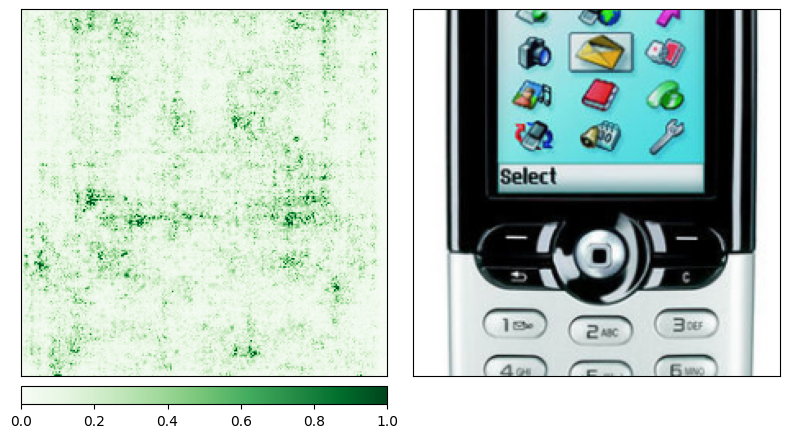

In [20]:
_3 = viz.visualize_image_attr_multiple(np.transpose(attr_saliency[2].numpy(), (1,2,0)),
                                       np.array(all_images[2]),
                                       ["heat_map", "original_image"],
                                       ["positive", "positive"],
                                       show_colorbar=True,
                                       outlier_perc=2,
                                       )

In [21]:
def sample_xai(images):
    if images.shape[0] == 1:
        target = single_pred
    else:
        target = single_pred.repeat(images.shape[0])
    xai = occlusion.attribute(images,
                              strides = (3, 40, 40),
                              target=target,
                              sliding_window_shapes=(3,50, 50),
                              baselines=0)
    return xai
#Metrics.stability(sample_xai, single_data.squeeze(dim=0), single_data.repeat(10,1,1,1))

# Ensembles

In [22]:
x = torch.cat([attributions_occ, attributions_ig_nt])
aggregated1 = Ensemble.basic(x, aggregating_func='avg')
aggregated2 = Ensemble.basic(x, aggregating_func='min')
aggregated3 = Ensemble.basic(x, aggregating_func='max')

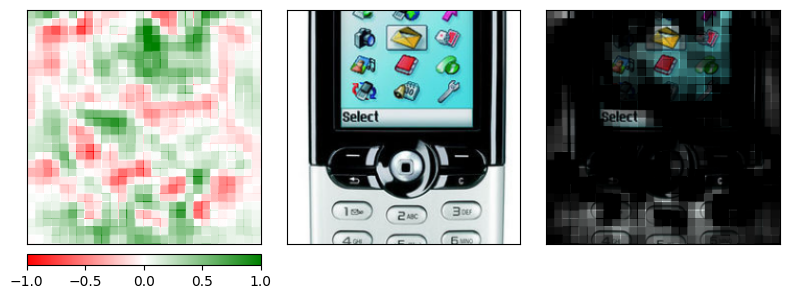

In [23]:
#display(transform.to_pil_image(aggregated1[0]))
_ = viz.visualize_image_attr_multiple(np.transpose(aggregated1.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image", "masked_image"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [24]:
all_stacked = torch.stack([attributions_occ_all_15, attributions_occ_all_25], dim=1)

In [25]:
attr_agg_avg = Ensemble.basic(all_stacked, aggregating_func='avg')
attr_agg_min = Ensemble.basic(all_stacked, aggregating_func='min')
attr_agg_max = Ensemble.basic(all_stacked, aggregating_func='max')

In [26]:
plt.style.use('fast')

In [27]:
def plot_explanations(images, explanations_dict, classes_predicted,
                      #cmaps=[default_cmap, None, None, None, None, None, None],
                      method = "heat_map"):
    nrow, ncol = len(images), len(explanations_dict.keys())+1
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize=(14, 3*nrow))
    columns_names = ["Original"] + list(explanations_dict.keys())
    for col, col_name in zip(ax[0], columns_names):
        col.title.set_text(col_name)
    for i, img in enumerate(images):
        ax[i,0].xaxis.set_ticks_position("none")
        ax[i,0].yaxis.set_ticks_position("none")
        ax[i,0].set_yticklabels([])
        ax[i,0].set_xticklabels([])
        ax[i,0].imshow(np.array(images[i]), vmin=0, vmax=255)
        ax[i,0].set_ylabel(classes_predicted[i], size='large')
        for j, (col, (key, explanations)) in enumerate(zip(ax[i,1:], explanations_dict.items())):
            #ith image, jth explanation
            #expl = explanations[i,j]
            expl = explanations[j]
            sign = "all"
            cmap=None
            if expl.amin() >= 0:
                sign = "positive"
                cmap = default_cmap
            _ = viz.visualize_image_attr(np.transpose(expl.squeeze().numpy(), (1,2,0)),
                                         original_image=np.array(img),
                                         method=method,
                                         sign=sign,
                                         plt_fig_axis=(fig, col),
                                         show_colorbar=True,
                                         outlier_perc=2,
                                         cmap=cmap,
                                         use_pyplot=False
                                         )
    plt.savefig(f"results/{id}/plots.png")
    plt.show()

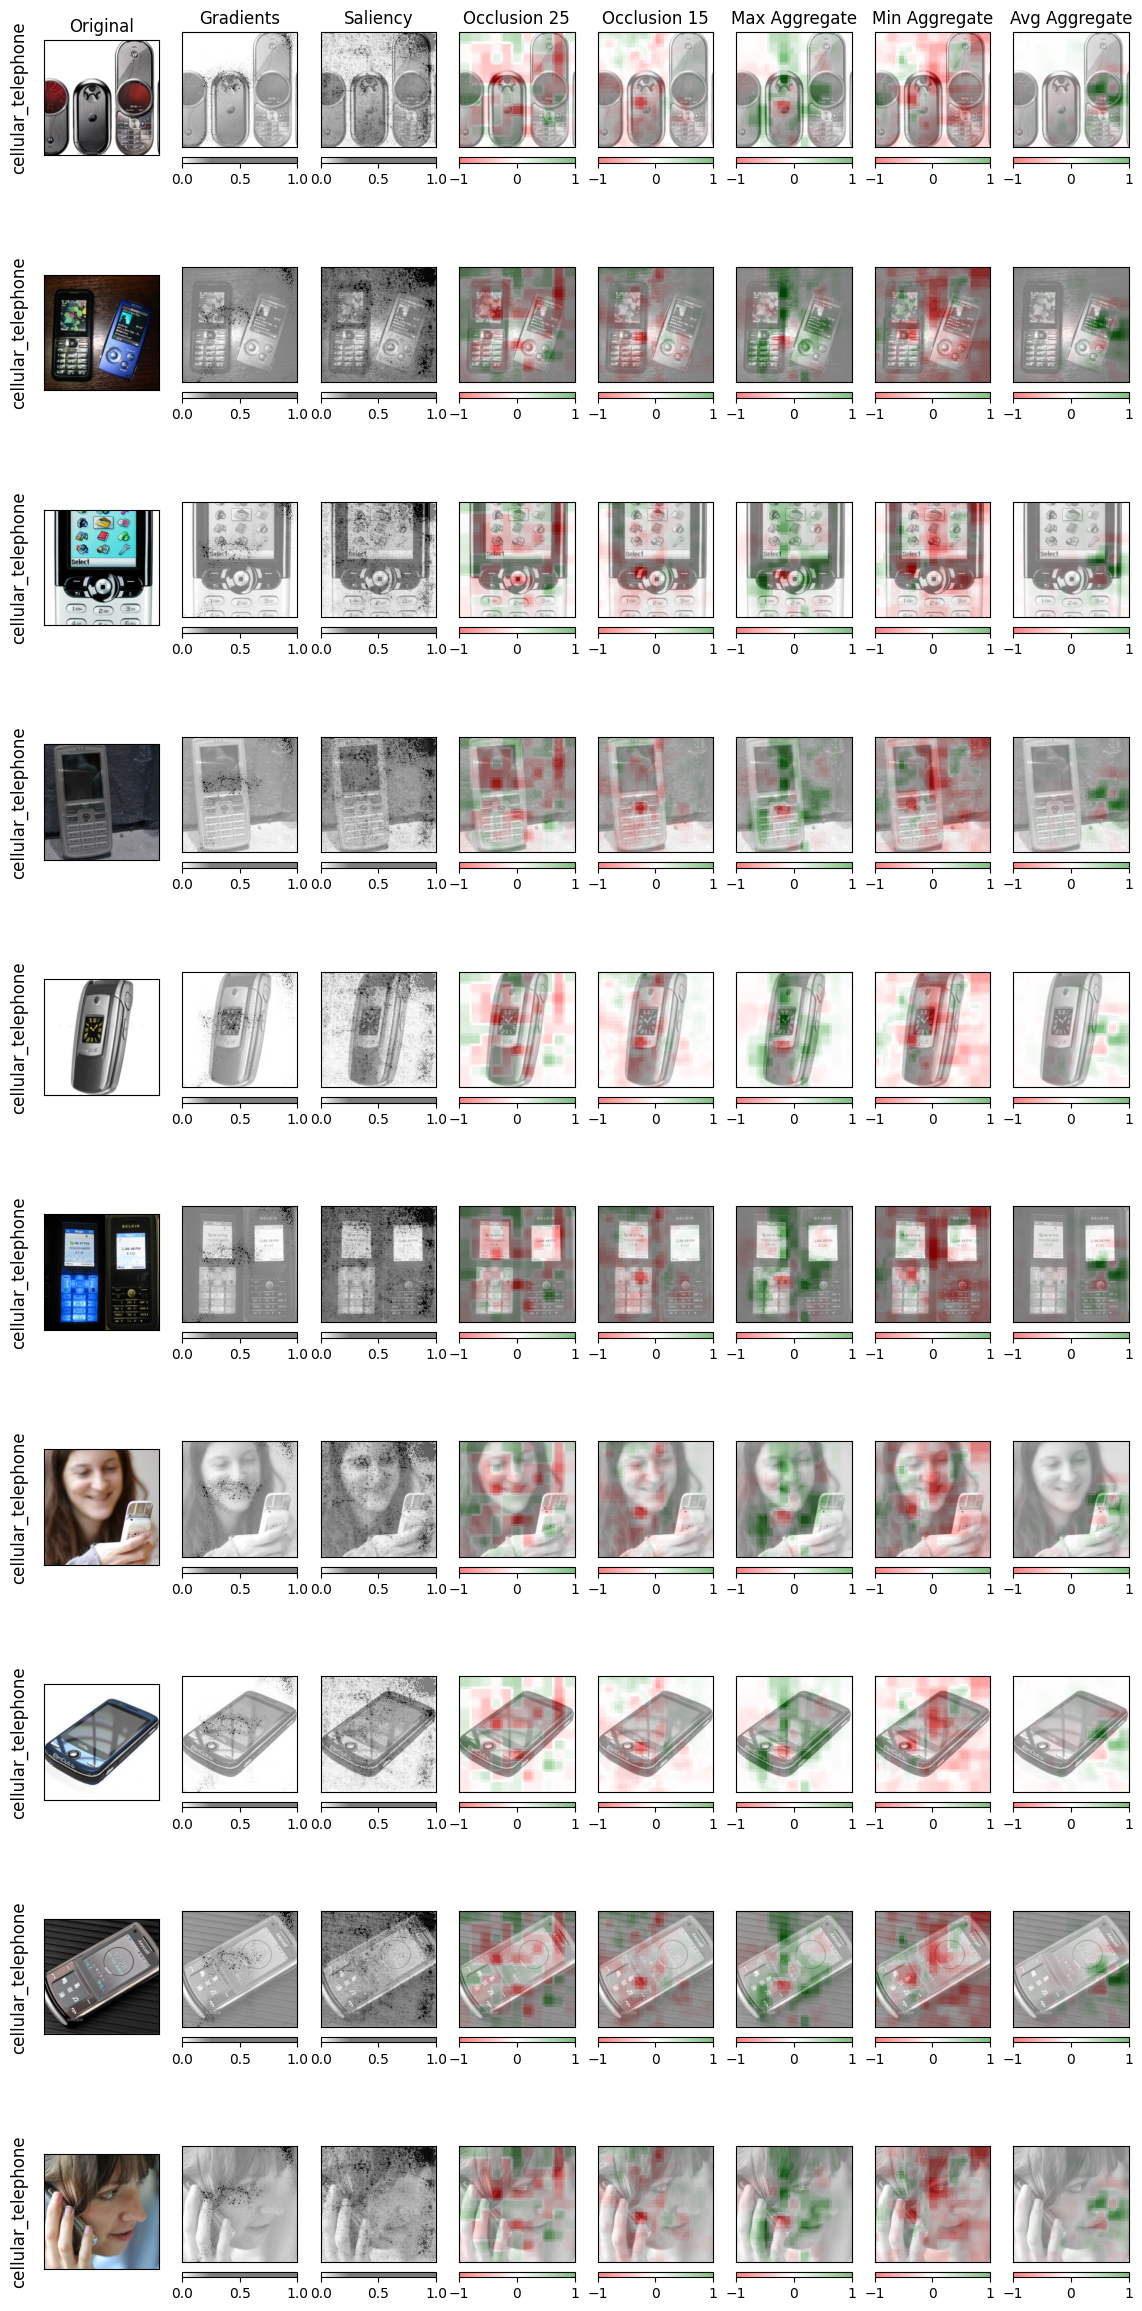

In [28]:
expl_dict = {"Gradients":attributions_ig_nt_all, "Saliency":attr_saliency, "Occlusion 25":attributions_occ_all_25,
             "Occlusion 15":attributions_occ_all_15, "Max Aggregate":attr_agg_max,
             "Min Aggregate":attr_agg_min, "Avg Aggregate":attr_agg_avg}
predicted_names = [imagenet_classes_dict[str(i.item())][1] for i in preds2]
plot_explanations(all_images, expl_dict, predicted_names, method="blended_heat_map")

In [29]:
predict = lambda x: torch.nn.Softmax(dim=0)(model(x))
per_explanation = dict_to_matrix(proper_data, expl_dict, predict, tensor_masks)

In [30]:
per_explanation

Decision Impact Ratio0  Confidence Impact Ratio Same0  \
Gradients                         1.0                       0.436897   
Saliency                          1.0                       0.436897   
Occlusion 25                      0.7                       0.144982   
Occlusion 15                      1.0                       0.186066   
Max Aggregate                     1.0                       0.167520   
Min Aggregate                     0.7                       0.098137   
Avg Aggregate                     0.9                       0.172855   

               CIR Max0  Average Recall0  Average Precision0  \
Gradients      0.436897         1.000000            0.461583   
Saliency       0.436897         1.000000            0.461583   
Occlusion 25  -0.015015         0.462697            0.460375   
Occlusion 15  -0.180236         0.432273            0.463350   
Max Aggregate -0.180529         0.574752            0.465171   
Min Aggregate -0.070038         0.320219            0.455367   
Avg Aggregate -0.119849         0.435014            0.460831   

               Decision Impact Ratio1  Confidence Impact Ratio Same1  \
Gradients                         0.0                       0.000000   
Saliency                          0.5                       0.071062   
Occlusion 25                      0.6                       0.062297   
Occlusion 15                      0.8                       0.027215   
Max Aggregate                     0.6                       0.056645   
Min Aggregate                     0.7                       0.031210   
Avg Aggregate                     0.7                       0.003982   

               CIR Max1  Average Recall1  Average Precision1  ...  CIR Max8  \
Gradients      0.000000         0.000000            0.000000  ...  0.000000   
Saliency       0.005249         0.052544            0.646580  ...  0.001331   
Occlusion 25  -0.056515         0.214583            0.644255  ... -0.003348   
Occlusion 15  -0.064125         0.142669            0.737521  ... -0.002192   
Max Aggregate -0.069681         0.239085            0.653754  ... -0.003348   
Min Aggregate -0.042101         0.118166            0.699133  ... -0.002192   
Avg Aggregate -0.100585         0.172901            0.660126  ... -0.018806   

               Average Recall8  Average Precision8  Decision Impact Ratio9  \
Gradients             0.000000            0.000000                     0.0   
Saliency              0.000169            0.266667                     0.0   
Occlusion 25          0.033840            0.141484                     0.1   
Occlusion 15          0.003157            0.183333                     0.0   
Max Aggregate         0.033840            0.141484                     0.1   
Min Aggregate         0.003157            0.183333                     0.0   
Avg Aggregate         0.014043            0.181250                     0.1   

               Confidence Impact Ratio Same9  CIR Max9  Average Recall9  \
Gradients                           0.000000  0.000000         0.000000   
Saliency                           -0.000557 -0.000557         0.000074   
Occlusion 25                        0.029524 -0.006381         0.028738   
Occlusion 15                        0.002118  0.002118         0.000350   
Max Aggregate                       0.029524 -0.006381         0.028738   
Min Aggregate                       0.002118  0.002118         0.000350   
Avg Aggregate                       0.019012 -0.000077         0.003802   

               Average Precision9  F1_score       IOU  
Gradients                0.000000  0.588383  0.000000  
Saliency                 0.200000  0.588383  0.000861  
Occlusion 25             0.160893  0.405486  0.044388  
Occlusion 15             0.200000  0.389600  0.026406  
Max Aggregate            0.160893  0.460370  0.044593  
Min Aggregate            0.200000  0.316428  0.026136  
Avg Aggregate            0.191176  0.389007  0.039917  

[7 rows x 52 columns]

In [31]:
per_image = pd.DataFrame()
per_image["Average Recall"] = torch.mean(torch.stack([Metrics.accordance_recall(expl, tensor_masks, 0.2) for expl in expl_dict.values()]), dim=0).numpy()
per_image["Average Precision"] = torch.mean(torch.stack([Metrics.accordance_precision(expl, tensor_masks, 0.2) for expl in expl_dict.values()]), dim=0).numpy()
per_image["Consistency"] = [Metrics.consistency(expls) for expls in torch.stack(list(expl_dict.values()), dim=1)]
per_image

Average Recall  Average Precision  Consistency
0        0.048769           0.787010     0.033001
1        0.002727           0.432630     0.040016
2        0.000010           0.428571     0.042628
3        0.005273           0.408992     0.033505
4        0.092992           0.669689     0.019822
5        0.003731           0.571976     0.038813
6        0.256327           0.384612     0.015813
7        0.022801           0.712391     0.041238
8        0.034744           0.729495     0.029903
9        0.225770           0.296060     0.015923

In [32]:
a=expl_dict
with open(f'results/{id}/explanations.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
per_explanation.to_csv(f'results/{id}/per_expl.csv')
per_image.to_csv(f'results/{id}/per_image.csv')
with open(f'results/{id}/explanations.pickle', 'rb') as handle:
    b = pickle.load(handle)
b.keys()

dict_keys(['Gradients', 'Saliency', 'Occlusion 25', 'Occlusion 15', 'Max Aggregate', 'Min Aggregate', 'Avg Aggregate'])